## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy
from optimization.functions import read_each_loader, convert_sample_2_df, trajectory_estimation

from models.policy_model import RobotPolicy

In [2]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory)

Evaluating Device:  cpu
Current Time:  Jan_31_2024-12_40_56


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load demonstrations dataset
evaluation_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  10
Full Demo Dataset Size:  406


# Functions

In [6]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

# Test

In [7]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Jan_31_2024-09_57_07"

In [8]:
params_name = "policy_network_epoch_100_loss_3_83506.pt"

In [9]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [10]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [11]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [12]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

In [13]:
sample_index = 25

In [14]:
evaluation_sample = evaluation_data[sample_index]

In [15]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [16]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))

In [17]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [18]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=evaluation_data.state_norms)

In [19]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=evaluation_data.action_norms)[0]

In [20]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=evaluation_data.action_norms)[0]

# Run Through All Samples in a Trajectory for Every Trajectory

In [21]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [22]:
for idx, sample_data in enumerate(evaluation_data):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=sample_data)
    
    # add a batch dimension by unsqueezing
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))
    
    # multivariate Gaussian negative log-likelihood loss function
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=evaluation_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                                   norm_range_list=evaluation_data.action_norms)[0]
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=evaluation_data.action_norms)[0]
    
    # store every important detail in the dataframe
    sample_df = convert_sample_2_df(input_state=input_state,
                                    real_state_input=real_state_input,
                                    output_action=output_action,
                                    real_action_output=real_action_output,
                                    action_log_prob=action_log_prob,
                                    action_pred=action_pred,
                                    action_std=action_std,
                                    real_action_pred=real_action_pred,
                                    trajectory_index=int(trajectory_index),
                                    state_number=int(state_number),
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        df = pd.concat([df, sample_df],
                       ignore_index=True)
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

In [23]:
trajectory_dataframes[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,...,action_pred_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss
0,0.557423889637,0.838066339493,0.152274101973,0.438123047352,1.114847779274,1.676132678986,0.304548203945,0.876246094704,-0.206786960363,-0.263957113028,...,0.383507430553,0.358997941017,0.358992815018,0.359004110098,-0.424899339676,-0.478325724602,0.767014980316,41,0,3.834680080414
1,0.467088162899,0.770086586475,0.106058746576,0.413727521896,0.934176325798,1.540173172951,0.212117493153,0.827455043793,-0.274574905634,-0.117239050567,...,0.363113641739,0.358997941017,0.358992815018,0.359004110098,-0.513029098511,-0.315182566643,0.726227283478,41,1,3.834450721741
2,0.289939045906,0.662430644035,0.177682518959,0.421456843615,0.579878091812,1.324861288071,0.355365037918,0.842913687229,-0.280997991562,0.046184424311,...,0.354888916016,0.358997941017,0.358992815018,0.359004110098,-0.647792816162,0.114635229111,0.709777832031,41,2,3.834376811981
3,0.189123824239,0.549174249172,0.317737460136,0.420233011246,0.378247648478,1.098348498344,0.635474920273,0.840466022491,-0.258398354053,0.182242289186,...,0.328464090824,0.358997941017,0.358992815018,0.359004110098,-0.616078019142,0.403352737427,0.656928062439,41,3,3.834565401077
4,0.203070998192,0.452439308167,0.439699143171,0.396792560816,0.406141996384,0.904878616333,0.879398286343,0.793585121632,-0.233832702041,0.278123915195,...,0.285796999931,0.358997941017,0.358992815018,0.359004110098,-0.505188584328,0.587595462799,0.571593999863,41,4,3.834154129028
5,0.230293363333,0.361929088831,0.520886838436,0.341573148966,0.460586726665,0.723858177662,1.041773676872,0.683146297932,-0.229463696480,0.273556470871,...,0.200377553701,0.358997941017,0.358992815018,0.359004110098,-0.442839026451,0.677781820297,0.400755167007,41,5,3.835203647614
6,0.243417412043,0.275898158550,0.547509610653,0.247494399548,0.486834824085,0.551796317101,1.095019221306,0.494988799095,-0.219121053815,0.333380490541,...,0.124865360558,0.358997941017,0.358992815018,0.359004110098,-0.433094620705,0.661273241043,0.249730825424,41,6,3.835945367813
7,0.313775777817,0.132531851530,0.630524098873,0.115627251565,0.627551555634,0.265063703060,1.261048197746,0.231254503131,-0.179725974798,0.333937913179,...,0.003845055820,0.358997941017,0.358992815018,0.359004110098,-0.390524744987,0.725505352020,0.007690191269,41,7,3.834168910980
8,0.358732581139,0.085160508752,0.652878761292,0.068153508008,0.717465162277,0.170321017504,1.305757522583,0.136307016015,-0.167760327458,0.361364185810,...,-0.037496816367,0.358997941017,0.358992815018,0.359004110098,-0.346947193146,0.731662273407,-0.074993610382,41,8,3.833964347839


In [24]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

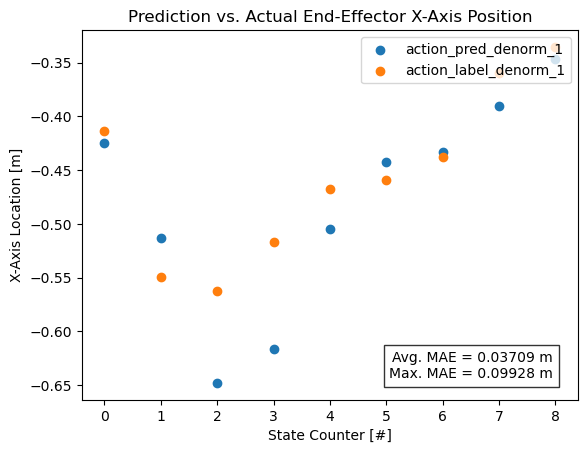

In [25]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

In [26]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

In [27]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

trajectory_estimation(configs=configs,
                      data_loader=evaluation_data,
                      policy_network=policy_network,
                      trajectory_length=constants.TRAJECTORY_SIZE)


state_number :  0
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.4112674  -0.30779302  0.60889959]
current_state_denorm_estimation :  [0.81735593 1.34013021 0.06278246 0.71944666]
next_state_denorm_label :  [0.86942815 1.32989333 0.         0.77739959]

state_number :  1
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.58261347 -0.22063708  0.68234015]
current_state_denorm_estimation :  [0.8272838  1.27173817 0.07166497 0.77296954]
next_state_denorm_label :  [1.01522468 1.32470659 0.20578908 0.85084015]

state_number :  2
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.69073534  0.03005457  0.68693328]
current_state_denorm_estimation :  [0.6963225  1.25926971 0.18273279 0.79314524]
next_state_denorm_label :  [1.09921705 1.17841894 0.44534546 0.85543328]

state_number :  3
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  

In [28]:
trajectory_dataframes[0][["state_label_denorm_1", "state_label_denorm_2", "state_label_denorm_3", "state_label_denorm_4",
                          "action_label_denorm_1", "action_label_denorm_2", "action_label_denorm_3",
                          "state_number", "trajectory_index"]]

,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,state_number,trajectory_index
0,0.817355930805,1.340130209923,0.062782458961,0.719446659088,-0.411267399788,-0.307793021202,0.608899593353,0,0
1,0.749341726303,1.329893350601,0.091292686760,0.777399659157,-0.582613468170,-0.220637083054,0.682340145111,1,0
2,0.610901355743,1.324706554413,0.330848038197,0.850840091705,-0.690735340118,0.030054569244,0.686933279037,2,0
3,0.403398275375,1.178418993950,0.579016268253,0.855433344841,-0.707678318024,0.341165065765,0.698992729187,3,0
4,0.347195714712,1.028262019157,0.866340041161,0.867492616177,-0.569955348969,0.637730121613,0.703000307083,4,0
5,0.560571551323,0.906139731407,1.109057188034,0.871500253677,-0.385704755783,0.734245300293,0.581532001495,5,0
6,0.671198368073,0.751323580742,1.194474816322,0.750032007694,-0.289792299271,0.727063417435,0.280845642090,6,0
7,0.691959977150,0.456819653511,1.219006538391,0.449345678091,-0.303528666496,0.762950897217,0.042779445648,7,0
8,0.758535563946,0.218809649348,1.321065306664,0.211279332638,-0.315587043762,0.773996353149,-0.116610527039,8,0


In [29]:
0.703000307083 + 0.1685

0.871500307083

In [30]:
trajectory_dataframes[0]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,...,action_pred_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss
0,0.408677965403,0.670065104961,0.031391229481,0.359723329544,0.817355930805,1.340130209923,0.062782458961,0.719446659088,-0.205633714795,-0.153896495700,...,0.302234739065,0.358997941017,0.358992815018,0.359004110098,-0.390273094177,-0.239415526390,0.604469537735,0,0,3.834123611450
1,0.374670863152,0.664946675301,0.045646343380,0.388699829578,0.749341726303,1.329893350601,0.091292686760,0.777399659157,-0.291306763887,-0.110318548977,...,0.325486451387,0.358997941017,0.358992815018,0.359004110098,-0.451546907425,-0.130607604980,0.650972843170,0,1,3.835412025452
2,0.305450677872,0.662353277206,0.165424019098,0.425420045853,0.610901355743,1.324706554413,0.330848038197,0.850840091705,-0.345367670059,0.015027273446,...,0.354707777500,0.358997941017,0.358992815018,0.359004110098,-0.613848924637,0.093384742737,0.709415435791,0,2,3.834446430206
3,0.201699137688,0.589209496975,0.289508134127,0.427716672421,0.403398275375,1.178418993950,0.579016268253,0.855433344841,-0.353839129210,0.170582592487,...,0.342462241650,0.358997941017,0.358992815018,0.359004110098,-0.667974948883,0.330800294876,0.684924602509,0,3,3.833925247192
4,0.173597857356,0.514131009579,0.433170020580,0.433746308088,0.347195714712,1.028262019157,0.866340041161,0.867492616177,-0.284977644682,0.318865031004,...,0.331036597490,0.358997941017,0.358992815018,0.359004110098,-0.650387287140,0.580602169037,0.662073135376,0,4,3.834506034851
5,0.280285775661,0.453069865704,0.554528594017,0.435750126839,0.560571551323,0.906139731407,1.109057188034,0.871500253677,-0.192852392793,0.367122590542,...,0.298334240913,0.358997941017,0.358992815018,0.359004110098,-0.483462810516,0.726220846176,0.596668481827,0,5,3.834411144257
6,0.335599184036,0.375661790371,0.597237408161,0.375016003847,0.671198368073,0.751323580742,1.194474816322,0.750032007694,-0.144896149635,0.363531738520,...,0.232088223100,0.358997941017,0.358992815018,0.359004110098,-0.353521227837,0.757920026779,0.464176416397,0,6,3.836165428162
7,0.345979988575,0.228409826756,0.609503269196,0.224672839046,0.691959977150,0.456819653511,1.219006538391,0.449345678091,-0.151764318347,0.381475418806,...,0.098064541817,0.358997941017,0.358992815018,0.359004110098,-0.314589977264,0.735019683838,0.196129083633,0,7,3.835299253464
8,0.379267781973,0.109404824674,0.660532653332,0.105639666319,0.758535563946,0.218809649348,1.321065306664,0.211279332638,-0.157793551683,0.386998146772,...,-0.017162568867,0.358997941017,0.358992815018,0.359004110098,-0.332967162132,0.748365879059,-0.034325122833,0,8,3.834281921387


In [31]:
trajectory_dataframes[0].columns

Index(['state_label_norm_1', 'state_label_norm_2', 'state_label_norm_3',
       'state_label_norm_4', 'state_label_denorm_1', 'state_label_denorm_2',
       'state_label_denorm_3', 'state_label_denorm_4', 'action_label_norm_1',
       'action_label_norm_2', 'action_label_norm_3', 'action_label_denorm_1',
       'action_label_denorm_2', 'action_label_denorm_3',
       'action_pred_logprob_1', 'action_pred_logprob_2',
       'action_pred_logprob_3', 'action_pred_1', 'action_pred_2',
       'action_pred_3', 'action_pred_std_1', 'action_pred_std_2',
       'action_pred_std_3', 'action_pred_denorm_1', 'action_pred_denorm_2',
       'action_pred_denorm_3', 'trajectory_index', 'state_number',
       'gnll_loss'],
      dtype='object')

In [32]:
np.log(2 * np.pi)

1.8378770664093453

In [33]:
0.80889959 - 0.777477681637

0.03142190836299996

In [34]:
0.2-0.03142190836299996

0.16857809163700005